In [20]:
import matplotlib.pyplot as plt
import pandas as pd
import torch

from datasets import load_dataset

# Text Classification
* Dataset: emotions
## Load Dataset

In [2]:
emotions = load_dataset("emotion")

Using custom data configuration default


Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Dataset emotion downloaded and prepared to /Users/SPayot/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

In [3]:
emotions

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 16000
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 2000
    })
})

### Exploratory Data Analysis

In [5]:
train_ds = emotions["train"]
print(f"train dataset length: {len(train_ds)}")
print(f"example: {train_ds[0]}")
print(f"column names: {train_ds.column_names}")
print(f"features: {train_ds.features}")


train dataset length: 16000
example: {'text': 'i didnt feel humiliated', 'label': 0}
column names: ['text', 'label']
features: {'text': Value(dtype='string', id=None), 'label': ClassLabel(num_classes=6, names=['sadness', 'joy', 'love', 'anger', 'fear', 'surprise'], id=None)}


,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


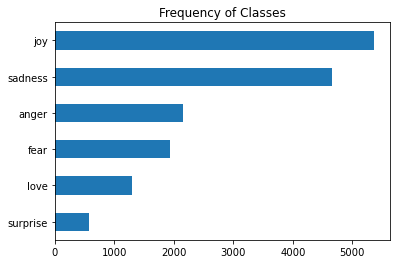

In [8]:
emotions.set_format(type="pandas")

# turn into a pd dataframe
df = emotions["train"][:]

# add label names
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
display(df.head())

# plot distribution of classes
df.label_name.value_counts(ascending=True).plot.barh()
plt.title("Frequency of Classes")
plt.show()

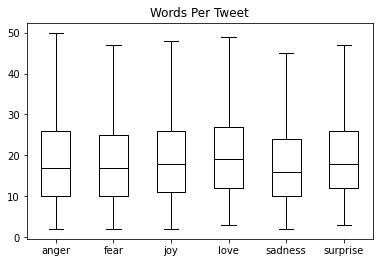

In [11]:
# distirbution of words per tweets
df["Words Per Tweet"] = df.text.str.split().apply(len)
df.boxplot("Words Per Tweet", by="label_name", grid=False,
showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

## Tokenization

In [18]:
from transformers import AutoTokenizer

emotions.reset_format()

MODEL_CKPT = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(MODEL_CKPT)

def tokenize(batch):
    return tokenizer(batch["text"], padding=True, truncation=True)

# example of tokenize
print(tokenize(emotions["train"][:2]))

{'input_ids': [[101, 1045, 2134, 2102, 2514, 26608, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [101, 1045, 2064, 2175, 2013, 3110, 2061, 20625, 2000, 2061, 9636, 17772, 2074, 2013, 2108, 2105, 2619, 2040, 14977, 1998, 2003, 8300, 102]], 'attention_mask': [[1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]]}


In [19]:
# tokenize full dataset
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=None)

print(emotions_encoded["train"].column_names)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

['text', 'label', 'input_ids', 'attention_mask']


## Transformers as Feature Extractors

* IDEA: freeze model weights and use last hidden state for CLS token as features to train a classifier against.

In [34]:
from transformers import AutoModel

MODEL_CKPT = "distilbert-base-uncased"

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = AutoModel.from_pretrained(MODEL_CKPT).to(device)

# example inference
text = "i would like to make a test."
inputs = tokenizer(text, return_tensors="pt")

print("Input tensor shape:", inputs["input_ids"].size(), sep='\t')


Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertModel: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


Input tensor shape:	torch.Size([1, 10])


In [35]:
def extract_hidden_states(batch):
    inputs = {k:v.to(device) for k,v in batch.items()
        if k in tokenizer.model_input_names}
    # extract last hidden states
    with torch.no_grad():
        last_hidden_state = model(**inputs).last_hidden_state

    # return vector for [CLS] token
    return {"hidden_state": last_hidden_state[:,0].cpu().numpy()}

emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])
emotions_hidden = emotions_encoded.map(extract_hidden_states, batched=True)

print(emotions_hidden["train"].column_names)

  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

  0%|          | 0/2 [00:00<?, ?ba/s]

['text', 'label', 'input_ids', 'attention_mask', 'hidden_state']


### Creating a feature matrix

In [36]:
import numpy as np

X_train = np.array(emotions_hidden["train"]["hidden_state"])
X_valid = np.array(emotions_hidden["validation"]["hidden_state"])
y_train = np.array(emotions_hidden["train"]["label"])
y_valid = np.array(emotions_hidden["validation"]["label"])
X_train.shape, X_valid.shape

((16000, 768), (2000, 768))

### Visualizing the feature matrix
* project in 2D using UMAP (after Min Max scaling)
* look at 2D distribution of data for each labels

In [39]:
from umap import UMAP
from sklearn.preprocessing import MinMaxScaler

X_scaled = MinMaxScaler().fit_transform(X_train)

mapper = UMAP(n_components=2, metric="cosine").fit(X_scaled)

df_emb = pd.DataFrame(mapper.embedding_, columns=["X", "Y"])

df_emb["label"] = y_train

df_emb.head()

,X,Y,label
0,4.335134,6.635765,0
1,-2.937845,5.765030,0
2,5.189435,3.174321,3
3,-2.221439,3.529051,2
4,-3.146839,3.697892,3


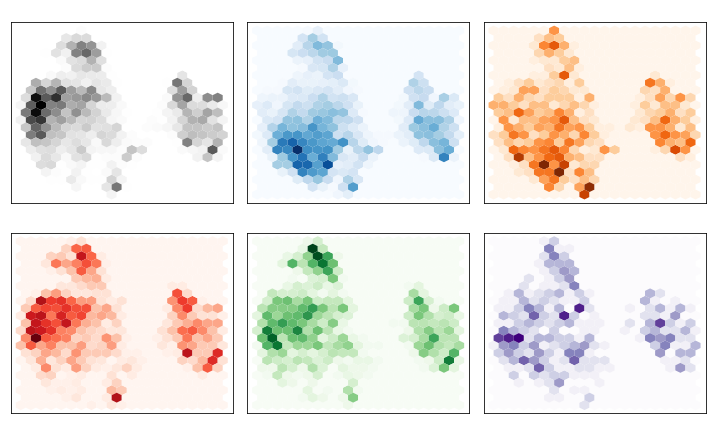

In [47]:
fig, axes = plt.subplots(2, 3, figsize=(10,6))
axes = axes.flatten()
cmaps = ["Greys", "Blues", "Oranges", "Reds", "Greens", "Purples"]
labels = emotions["train"].features["label"].names

for i, (label, cmap) in enumerate(zip(labels, cmaps)):
    df_emb_sub = df_emb.query(f"label == {i}")
    axes[i].hexbin(df_emb_sub["X"], df_emb_sub["Y"], cmap=cmap, 
        gridsize=20, linewidths=(0,))
    axes[i].set_title(label, c='white')
    axes[i].set_xticks([]), axes[i].set_yticks([])
plt.tight_layout()
plt.show()

### Fitting a linear classifier
* using logistic regression
* compare to baseline of majority class selection

In [72]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

lr_clf = LogisticRegression(max_iter=3000)
lr_clf.fit(X_train, y_train)

def get_metrics(clf):
    preds = clf.predict(X_valid)
    scores = {
        'f1-score': f1_score(y_valid, preds, average='weighted'), 
        "accuracy": accuracy_score(y_valid, preds)}

    return scores

get_metrics(lr_clf)

{'f1-score': 0.6209011460283067, 'accuracy': 0.633}

### Baseline: Dummy Classifier

In [73]:
from sklearn.dummy import DummyClassifier

dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(X_train, y_train)

get_metrics(dummy_clf)

{'f1-score': 0.18328994082840236, 'accuracy': 0.352}

### Plot confusion Matrix fo rmodel fine tuning

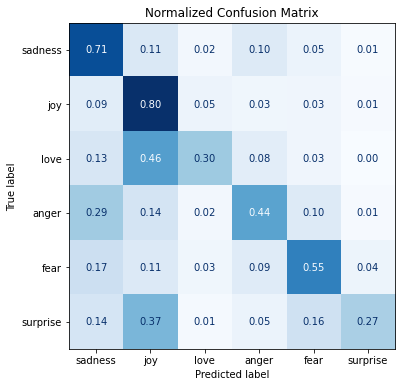

In [80]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds: np.ndarray, y_true: np.ndarray, labels: np.ndarray):
    cm = confusion_matrix(y_valid, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6,6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized Confusion Matrix")
    plt.show()

preds = lr_clf.predict(X_valid)

plot_confusion_matrix(preds, y_valid, labels)


## Fine-Tuning Transformers

In [74]:
from transformers import AutoModelForSequenceClassification

# load model
num_labels = emotions["train"].features["label"].num_classes
model = (AutoModelForSequenceClassification
    .from_pretrained(MODEL_CKPT, num_labels=num_labels)
    .to(device))

# define metrics to compute
def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}



Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.weight', 'vocab_transform.bias', 'vocab_projector.bias', 'vocab_transform.weight', 'vocab_layer_norm.weight', 'vocab_layer_norm.bias']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'pre_classifier.weight', 'classifier

In [76]:

BATCH_SIZE = 64

config = {
    "output_dir": f"{MODEL_CKPT}-finetuned-emotions",
    "num_train_epochs": 2,
    "learning_rate": 2e-5,
    "per_device_train_batch_size": BATCH_SIZE,
    "per_device_eval_batch_size": BATCH_SIZE,
    "weight_decay": 0.01,
    "evaluation_strategy": "epoch",
    "disable_tqdm": False,
    "logging_steps": len(emotions_encoded["train"]) // BATCH_SIZE,
    "push_to_hub": False,
    "log_level": "error",
}

In [78]:
from transformers import Trainer, TrainingArguments

training_args = TrainingArguments(**config)

trainer = Trainer(
    model=model, 
    args=training_args,
    compute_metrics=compute_metrics,
    train_dataset=emotions_encoded["train"],
    eval_dataset=emotions_encoded["validation"],
    tokenizer=tokenizer)

trainer.train();


  0%|          | 0/500 [00:00<?, ?it/s]

{'loss': 0.5469, 'learning_rate': 1e-05, 'epoch': 1.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.23846906423568726, 'eval_accuracy': 0.923, 'eval_f1': 0.9223660293803384, 'eval_runtime': 17.2818, 'eval_samples_per_second': 115.729, 'eval_steps_per_second': 1.852, 'epoch': 1.0}
{'loss': 0.2064, 'learning_rate': 0.0, 'epoch': 2.0}


  0%|          | 0/32 [00:00<?, ?it/s]

{'eval_loss': 0.19065047800540924, 'eval_accuracy': 0.928, 'eval_f1': 0.9280869646111781, 'eval_runtime': 17.7464, 'eval_samples_per_second': 112.699, 'eval_steps_per_second': 1.803, 'epoch': 2.0}
{'train_runtime': 1195.8929, 'train_samples_per_second': 26.758, 'train_steps_per_second': 0.418, 'train_loss': 0.3766786422729492, 'epoch': 2.0}


### Evaluate

{'test_loss': 0.19065047800540924, 'test_accuracy': 0.928, 'test_f1': 0.9280869646111781, 'test_runtime': 17.2056, 'test_samples_per_second': 116.241, 'test_steps_per_second': 1.86}


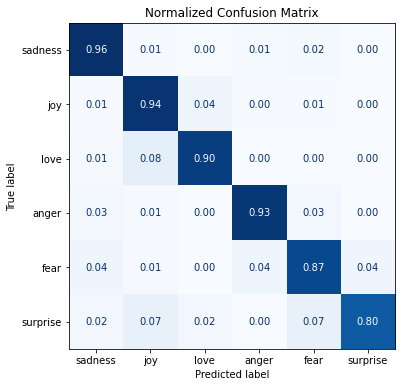

In [81]:
preds_output = trainer.predict(emotions_encoded["validation"])
print(preds_output.metrics)

y_preds = np.argmax(preds_output.predictions, axis=1)
plot_confusion_matrix(y_preds, y_valid, labels)

In [2]:
from src import plot 
plot.plot_confusion_matrix(y_preds, y_valid, labels)

NameError: name 'y_preds' is not defined

## Error Analysis

In [85]:
emotions_encoded["validation"]

Dataset({
    features: ['text', 'label', 'input_ids', 'attention_mask'],
    num_rows: 2000
})

In [87]:
from torch.nn import functional as F

def forward_pass_with_label(batch):
    # place all input tensors on the same device than the model
    inputs = {k: v.to(device) for k, v in batch.items()
                if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = F.cross_entropy(output.logits, batch["label"].to(device), reduction="none")

    return {"loss": loss.cpu().numpy(), 
            "predicted_label": pred_label.cpu().numpy()}

emotions_encoded.set_format("torch", columns=["input_ids", "attention_mask", "label"])

# Compute loss for all validation examples
emotions_encoded["validation"] = emotions_encoded["validation"].map(forward_pass_with_label, batched=True, batch_size=16)



  0%|          | 0/125 [00:00<?, ?ba/s]

In [92]:
# create dataframe
emotions_encoded.set_format("pandas")
cols = ["text", "label", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]

# replace label ids by strings
for col in ["label", "predicted_label"]:
    df_test[col] = df_test[col].apply(label_int2str)

df_test.head()


,text,label,predicted_label,loss
0,im feeling quite sad and sorry for myself but ...,sadness,sadness,0.012200
1,i feel like i am still looking at a blank canv...,sadness,sadness,0.012875
2,i feel like a faithful servant,love,love,0.325482
3,i am just feeling cranky and blue,anger,anger,0.023312
4,i can have for a treat or if i am feeling festive,joy,joy,0.010453


### Examples with highest loss

In [94]:
pd.set_option('display.max_colwidth', None)
df_test.sort_values("loss", ascending=False).head(10)

,text,label,predicted_label,loss
1500,i guess we would naturally feel a sense of loneliness even the people who said unkind things to you might be missed,anger,sadness,5.899096
1950,i as representative of everything thats wrong with corporate america and feel that sending him to washington is a ludicrous idea,surprise,sadness,5.465078
1963,i called myself pro life and voted for perry without knowing this information i would feel betrayed but moreover i would feel that i had betrayed god by supporting a man who mandated a barely year old vaccine for little girls putting them in danger to financially support people close to him,joy,sadness,5.282934
1274,i am going to several holiday parties and i can t wait to feel super awkward i am going to several holiday parties and i can t wait to feel super awkward a href http badplaydate,joy,sadness,5.274868
1111,im lazy my characters fall into categories of smug and or blas people and their foils people who feel inconvenienced by smug and or blas people,joy,fear,5.226892
882,i feel badly about reneging on my commitment to bring donuts to the faithful at holy family catholic church in columbus ohio,love,sadness,5.150527
1509,i guess this is a memoir so it feels like that should be fine too except i dont know something about such a deep amount of self absorption made me feel uncomfortable,joy,fear,4.948858
1870,i guess i feel betrayed because i admired him so much and for someone to do this to his wife and kids just goes beyond the pale,joy,sadness,4.897786
1801,i feel that he was being overshadowed by the supporting characters,love,sadness,4.844530
1964,i feel vaguely cheated and a little amused,joy,anger,4.214682


### Examples with lowest loss

In [95]:
df_test.sort_values("loss", ascending=True).head(10)

,text,label,predicted_label,loss
1873,i feel practically virtuous this month i have not exceeded my target of only buying things,joy,joy,0.008910
260,i am feeling so invigorated and so ready to keep pushing on to goal,joy,joy,0.008977
578,i got to christmas feeling positive about the future and hopeful that hospital admissions were finally behind me,joy,joy,0.009123
1012,i definitely succumbed to pre holiday sales but i feel good going into the holiday season i probably shouldnt say that though,joy,joy,0.009139
199,i feel invigorated full of energy ready for the day ahead,joy,joy,0.009200
1263,i feel this way about blake lively,joy,joy,0.009284
669,i am not feeling very joyful today its been a rough day,joy,joy,0.009313
1028,im now winded at the end of a tough rally but during the rally i feel good enough to stay in the point,joy,joy,0.009346
845,i already feel very glamorous have a great day everybody,joy,joy,0.009454
11,i was dribbling on mums coffee table looking out of the window and feeling very happy,joy,joy,0.009538


In [1]:
import torch

device = torch.device("mps" if torch.backends.mps.is_available() else "cpu")
device

device(type='mps')